In [40]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
raw_data = pd.read_csv('data/bike_sharing_demand.csv')

In [20]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [21]:
raw_data.shape

(10886, 12)

In [22]:
raw_data.isnull().values.any()

False

In [23]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


# prepare data

In [24]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [25]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


In [26]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [27]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [28]:
print('train_data perid from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('hold_out_test_data period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train_data perid from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
hold_out_test_data period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


In [29]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [30]:
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [32]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)

In [33]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [34]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [35]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [36]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)

In [37]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


# pipeline

In [38]:
regressor = linear_model.SGDRegressor(random_state=0, n_iter=3, loss='squared_loss', penalty='l2')

In [45]:
estimator = pipeline.Pipeline(steps=[
        ('feature_processing', pipeline.FeatureUnion(transformer_list=[
                    # binary
                    ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])),
                    
                    # numeric
                    ('numeric_variables_preprocessing', pipeline.Pipeline(steps=[
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                                ('scaling', preprocessing.StandardScaler(with_mean=0.0))
                            ])),
                    
                    # categorical
                    ('categorical_variables_preprocessing', pipeline.Pipeline(steps=[
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ])),
                ])),
        ('model_fitting', regressor)
    ])

In [46]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000BFB16877B8>, pass_y=False,
          validate=True)), ('numeric_variables_preprocessing', Pipeline(steps...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))])

In [47]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806858

In [50]:
estimator.get_params().keys()

dict_keys(['model_fitting__epsilon', 'feature_processing__numeric_variables_preprocessing__scaling__with_mean', 'model_fitting__loss', 'feature_processing', 'model_fitting__warm_start', 'feature_processing__numeric_variables_preprocessing__steps', 'model_fitting', 'feature_processing__categorical_variables_preprocessing__steps', 'feature_processing__categorical_variables_preprocessing', 'feature_processing__numeric_variables_preprocessing__scaling', 'feature_processing__categorical_variables_preprocessing__selecting__validate', 'feature_processing__numeric_variables_preprocessing__selecting', 'model_fitting__verbose', 'feature_processing__categorical_variables_preprocessing__hot_encoding', 'model_fitting__shuffle', 'model_fitting__l1_ratio', 'feature_processing__numeric_variables_preprocessing', 'model_fitting__power_t', 'model_fitting__eta0', 'feature_processing__numeric_variables_preprocessing__scaling__copy', 'feature_processing__binary_variables_processing__pass_y', 'model_fitting_

In [60]:
parameters_grid = {
    'model_fitting__alpha': [0.0001, 0.001, 0.1],
    'model_fitting__eta0': [0.001, 0.05]
}

In [61]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=4)

In [62]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 571 ms


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000BFB16877B8>, pass_y=False,
          validate=True)), ('numeric_variables_preprocessing', Pipeline(steps...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.0001, 0.001, 0.1], 'model_fitting__eta0': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [63]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-104.61097793
{'model_fitting__alpha': 0.1, 'model_fitting__eta0': 0.05}


In [64]:
test_prediction = grid_cv.best_estimator_.predict(test_data)

In [65]:
metrics.mean_absolute_error(test_labels, test_prediction)

126.17670701473044

In [66]:
print(test_labels[:10])
print(test_prediction[:10])

[525 835 355 222 228 325 328 308 346 446]
[ 143.24020824  166.18559326  212.41847539  243.66840089  262.21027027
  255.95729611  280.35929884  307.46605276  313.16392458  323.56466813]


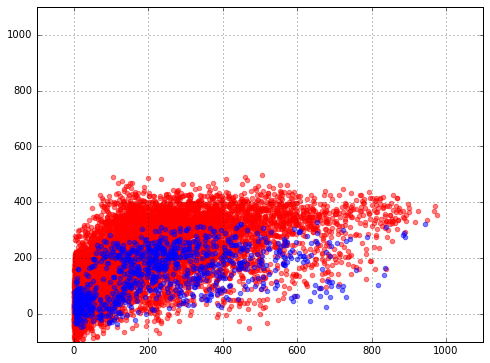

In [67]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')

# better model

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)

In [71]:
estimator = pipeline.Pipeline(steps=[
        ('feature_processing', pipeline.FeatureUnion(transformer_list=[
                    # binary
                    ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])),
                    
                    # numeric
                    ('numeric_variables_preprocessing', pipeline.Pipeline(steps=[
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                                ('scaling', preprocessing.StandardScaler(with_mean=0.0, with_std=1.0))
                            ])),
                    
                    # categorical
                    ('categorical_variables_preprocessing', pipeline.Pipeline(steps=[
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ])),
                ])),
        ('model_fitting', regressor)
    ])

In [72]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000BFB2282950>, pass_y=False,
          validate=True)), ('numeric_variables_preprocessing', Pipeline(steps..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [73]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.465803762612722

In [74]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [75]:
estimator.predict(test_data)[:10]

array([ 409.565     ,  505.56      ,  256.14066667,  165.5502619 ,
        206.48474784,  265.73960439,  254.49615818,  317.85774486,
        282.66963263,  441.59333333])

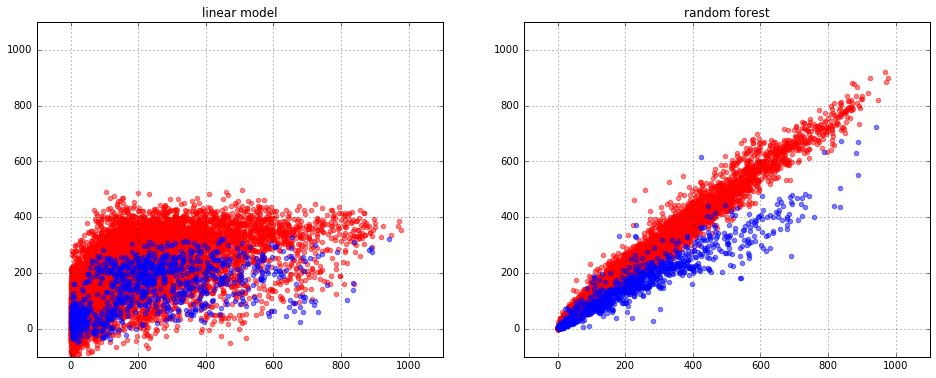

In [76]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1, 2, 1)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.title('linear model')

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color='blue')
pylab.title('random forest')